Горшенина Майя


##Какой язык?
Я буду разрабатывать систему транслитерации **хираганы** (один из трех методов письма на японском) **на русский**.

В японском есть два алфавита, хирагана и катакана, позволяющие записывать слова по слогам (примерно то же, что по буквам).
А также есть иероглифографическое письмо.

Я выбрала хирагану, поскольку она более распространена чем катакана в силу области применения, а транслитерация иероглифографического письма - работа на всю жизнь.

##Почему нужен трансдьюсер?

*   некоторые гласные редуцируются в определенном контексте
*   символ 2, следующий за символом 1, может менять прочтение символа 1
*   согласные и гласные могут удлинняться в зависимости от контекста

##Работа программы


*   Программа принимает предложение из файла с символами **unicode** и работает на основе номеров символов хираганы в таблицах unicode.
*   Предложение должно состаять только из символов хираганы и пробелов, иначе оно будет считаться некорректным







Правила, которые я учитываю (мб я не знаю еще каких-то правил)


*   сокуон (малое っ) удваивает следующую согласную. не может повиться в начале и в конце слова или перед гласной
*   Н перед билабиальными (П, Ф, Б, М) меняется на М (удвоение сокуоном происходит после замены)
*   И и У редуцируются в Ь и Ъ между двумя глухими согласными
*   У редуцируется до нуля на конце предложения в суффиксе СУ
*   малые гласные появляются только после слогов вида "согласный + И", делают новый слог
* гласная считается долгой, если после нее написана та же гласная (большая), или если после Э написано И (долгий Э), или если после О написано У



# Создание словаря символов

### Кортежи символов
В японском слоги бывают трех типов: гласный, согласный+гласный, слог N. Разобьем слоги по группам в соответствии со звуками, которые в них содержатся

Перечислим все слоги, в которых ест определенный звук. Это понадобится нам для самой транслитерации

примечание 1: символ=слог

примечание 2: в программе всегда используется код символа, и никогда - сам символ. поскольку названия переменных и функций и так состоят и кучи слов, я решила не добавлять к ним _code. мне кажется, это бы не облегчило а утяжелило чтение кода

In [35]:
# static data for interpreting ONLY
a_symbols = ('3042', '304b', '304c', '3055', '3056', '305f', '3060', '306a',
             '306f', '3070', '3071', '307e', '3084', '3089', '308f')
i_symbols = ('3044', '304d', '304e', '3057', '3058', '3061', '3062', '306b',
             '3072', '3073', '3074', '307f', '308a')
u_symbols = ('3046', '304f', '3050', '3059', '305a', '3064', '3065', '306c',
             '3075', '3076', '3077', '3080', '3086', '308b')
e_symbols = ('3048', '3051', '3052', '305b', '305c', '3066', '3067', '306d',
             '3078', '3079', '307a', '3081', '308c')
o_symbols = ('304a', '3053', '3054', '305d', '305e', '3068', '3069', '306e',
             '307b', '307c', '307d', '3082', '3088', '308d', '3092')

k_symbols = ('304b', '304d', '304f', '3051', '3053')
g_symbols = ('304c', '304e', '3050', '3052', '3054')
s_symbols = ('3055', '3059', '305b', '305d')
z_symbols = ('3056', '305a', '305c', '305e')
sh_symbols = ('3057',)
t_symbols = ('305f', '3066', '3068')
d_symbols = ('3060', '3067', '3069')
ts_symbols = ('3064',)
ch_symbols = ('3061',)
dz_symbols = ('3058', '3062', '3065')
n_symbols = ('306a', '306b', '306c', '306d', '306e',
             '3093') # includes the single-n syll
h_symbols = ('306f', '3072', '3078', '307b')
b_symbols = ('3070', '3073', '3076', '3079', '307c')
p_symbols = ('3071', '3074', '3077', '307a', '307d')
f_symbols = ('3075',)
m_symbols = ('307e', '307f', '3080', '3081', '3082')
y_symbols = ('3084', '3086', '3088')
r_symbols = ('3089', '308a', '308b', '308c', '308d')
w_symbols = ('308f', '3092')

Теперь перечислим все малые символы

In [36]:
small_tsu_symbols = ('3063',)
small_vowel_symbols = ('3083', '3085', '3087')

Теперь создадим кортежи символов в зависимости от их класса: определенные типы слогов и группы фонем. Это нужно для работы автомата

In [37]:
# static data for the automaton
stop_symbols = ('5e',)  # ^
space_symbols = ('20',)  # space
vowel_symbols = ('3042', '3044', '3046', '3048', '304a')  # single vowel syllables
cons_plus_vow_symbols = k_symbols + g_symbols + s_symbols + z_symbols + sh_symbols + \
                        t_symbols + d_symbols + ts_symbols + ch_symbols + dz_symbols + \
                        h_symbols + b_symbols + p_symbols + f_symbols + \
                        m_symbols + y_symbols + r_symbols + w_symbols + \
                        ('306a', '306b', '306c', '306d', '306e') # including n+vow syllables
n_syll_symbols = ('3093',)  # single n syllable

voiceless_symbols = k_symbols + s_symbols + sh_symbols + t_symbols + ts_symbols + ch_symbols + \
                    h_symbols + p_symbols + f_symbols
bilabial_symbols = m_symbols + b_symbols + p_symbols + f_symbols

### Функции для работы со словарем

сам автомат будет работать с номерами символов в таблице юникода. поэтому нам нужны функции, связывающие японские символы, автомат и русские символы

Функция которая принимает на вход символ (кодировка utf-8) и возвращает его 16-ричный код.

Это нужно, чтобы автомат по символу понимал, с чем работает. 16-ричный (а не 10-ричный) код используется в таблицах unicod и используется у меня в программе, чтобы удобнее было отслеживать ее работу

In [38]:
def get_code(char):
    return hex(ord(char)).lower()[2:]

И обратная функция для получения символа по 16-ричному коду (для вывода)

In [39]:
def get_symbol(order):
    return chr(int(order, 16))

Функция которая возвращает гласный звук, содержащийся в символе.

Принимает 16-ричный код символа, возвращает русскую букву. Если гласного звука нет (слог ん или вообще не японский символ) возвращает пустоту

In [40]:
def interpret_vow(syll_code):
    if syll_code in a_symbols:
        return "а"
    elif syll_code in i_symbols:
        return "и"
    elif syll_code in u_symbols:
        return "у"
    elif syll_code in e_symbols:
        return "э"
    elif syll_code in o_symbols:
        return "о"
    return '' # no vowel

Функция которая возвращает согласный звук, содержащийся в символе.

Работает по тому же принципу, что и предыдущая

In [41]:
def interpret_cons(syll_code):
    if syll_code in k_symbols:
        return "к"
    elif syll_code in g_symbols:
        return "г"
    elif syll_code in s_symbols:
        return "с"
    elif syll_code in z_symbols:
        return "з"
    elif syll_code in sh_symbols:
        return "щ"
    elif syll_code in t_symbols:
        return "т"
    elif syll_code in d_symbols:
        return "д"
    elif syll_code in ts_symbols:
        return "ц"
    elif syll_code in ch_symbols:
        return "ч"
    elif syll_code in dz_symbols:
        return "дз"
    elif syll_code in n_symbols:
        return "н"
    elif syll_code in h_symbols:
        return "х"
    elif syll_code in b_symbols:
        return "б"
    elif syll_code in p_symbols:
        return "п"
    elif syll_code in f_symbols:
        return "ф"
    elif syll_code in m_symbols:
        return "м"
    elif syll_code in y_symbols:
        return "й"
    elif syll_code in r_symbols:
        return "р"
    elif syll_code in w_symbols:
        return "у"  # уатащи
    return '' # no cons


Функция которая возвращает гласный звук, который замещает звук И в предыдущем слоге. (Ми + Я = Мя)

Работает по тому же принципу, что и предыдущая. Нужна для работы с малыми символами

In [42]:
def interpret_small_vow(syll_code):
    if syll_code == '3083':
        return "я"
    elif syll_code == '3085':
        return "ю"
    elif syll_code == '3087':
        return "ё"
    return ''

# Автомат

In [43]:
from collections import deque  # stack

Значение определенного символа может зависеть от предыдущих или последующих символов. Все символы, значение которых пока неоднозначно мы будем хранить в стеке.

Точнее, в стеке будет храниться символ и состояние, в котором этот символ был занесен в стек.

Напишем маленький класс, чтобы элементы стека были читабельнее

In [44]:
class MyStackUnit:
    syll = None  # unicode char (japanese)
    state = None  # state from which i came

    def __init__(self, syll, state):
        self.syll = syll
        self.state = state


    def __str__(self):
        return f'{get_symbol(self.syll)} from {self.state}'

И создадим функцию, которая выводит состояние автомата и стек в определенный момент

In [45]:
def print_state_and_stack(state):
    global need_clarifying_stack

    print(f'im in {state}, here is the stack: [ ', end='')
    stack_copy = need_clarifying_stack.copy()
    while stack_copy:
        print(stack_copy.pop(), end=', ') # stack means printing one at a time
    print(']')

### Базовые состояния

Базовые состояния автомата говорят о том, что на данную итерацию не влияет ничего, что происходило в автомате ранее.

Автомат работает по такому принципу: читается символ из входной строки, затем осуществляется переход в новое состояние (соответствующее этому символу) или выкидывается ошибка.

Например, если в начале слова не может быть малого っ, то попытка перейти из состояния begin_word в состояние small_tsu вызовет ошибку.

Теперь создадим первое состояние. В него автомат заходит, когда слово начинается.

В начале слова могут стоять слог гл, слог согл+гл, слог n

In [1]:
# state function (major)
def begin_word():
    global input_str
    global output_str
    global pos_in_input_str
    global need_clarifying_stack
    global error_occurred

    print_state_and_stack('begin_word')

    if pos_in_input_str >= len(input_str):
        return True  # empty line
    current_syll = get_code(input_str[pos_in_input_str])

    if current_syll in stop_symbols:
        pos_in_input_str += 1
        return True  # empty line

    if current_syll in space_symbols:
        pos_in_input_str += 1
        output_str += ' '
        begin_word()
        return True

    elif current_syll in small_tsu_symbols or current_syll in small_vowel_symbols:
        error_occurred = True  # a word cant begin with small symbs
        return False

    elif current_syll in vowel_symbols:
        vow_syll()
        return True

    elif current_syll in n_syll_symbols:
        n_syll()
        return True

    elif current_syll in cons_plus_vow_symbols:
        cons_from_cons_plus_vow_syll()
        return True

    else:
        error_occurred = True
        return False  # not japanese


Теперь создадим второе состояние. В него автомат заходит, когда на слог, который сейчас будет прочитан, ничего не влияет.

Это переходное состояние, которое вызывает другие состояния. В начале независимого слога могут стоять слог гл, слог согл+гл, слог n, малое っ

In [2]:
# state function (major)
def new_syll():
    global input_str
    global output_str
    global pos_in_input_str
    global need_clarifying_stack
    global error_occurred

    print_state_and_stack('new_syll')

    if pos_in_input_str >= len(input_str):
        return True   # end of word
    current_syll = get_code(input_str[pos_in_input_str])

    if current_syll in stop_symbols:
        pos_in_input_str += 1  # in case we need to verify if we checked all symbols
        return True  # end of word

    if current_syll in space_symbols:
        pos_in_input_str += 1  # end of word
        output_str += ' '
        begin_word()
        return True

    elif current_syll in small_tsu_symbols:
        small_tsu()
        return True

    elif current_syll in vowel_symbols:
        vow_syll()
        return True

    elif current_syll in small_vowel_symbols:
        error_occurred = True
        return False # syllables do not start with a small vowel

    elif current_syll in n_syll_symbols:
        n_syll()
        return True

    elif current_syll in cons_plus_vow_symbols:
        cons_from_cons_plus_vow_syll()
        return True

    else:
        error_occurred = True
        return False  # not japanese

### Состояния для конкретных слогов

В эти состояния автомат входит, когда ему на вход подается соответствующий тип слога

Создадим состояние для слога состоящего из одной гласной.

В этом состоянии реализовано правило удлиннения гласной.

In [48]:
# state function
def vow_syll():
    global input_str
    global output_str
    global pos_in_input_str
    global need_clarifying_stack
    global error_occurred

    print_state_and_stack('vow_syll')

    current_syll = get_code(input_str[pos_in_input_str])
    # not changing the pos bcs i was sent here after an input

    if need_clarifying_stack:
        previous_syll = need_clarifying_stack.pop().syll
        current_vow_rus = interpret_vow(current_syll)
        previous_vow_rus = interpret_vow(previous_syll)
        # the cons is already interpreted
        if current_vow_rus == 'у' and previous_vow_rus == 'о':
            output_str += "о" + "о"  # U prolongs O
        elif current_vow_rus == 'и' and previous_vow_rus == 'э':
            output_str += "э" + "э"  # I prolongs E
        else:
            output_str += previous_vow_rus + current_vow_rus
            # both same and different vowels
    else:
        output_str += interpret_vow(current_syll)

    pos_in_input_str += 1
    # switch to new syll bcs a vowel syll can't affect what's next
    new_syll()
    return True


Создадим состояние для слога состоящего из звука n.

В этом состоянии реализовано правило удлиннения согласной n.
Я повторяю 3 строчки кода, потому что мне нужно сначала очистить стек от потенциального малого っ, а потом уже переходить к другому символу

In [49]:
# state function
def n_syll():
    global input_str
    global output_str
    global pos_in_input_str
    global need_clarifying_stack
    global error_occurred

    print_state_and_stack('n_syll')

    current_syll = get_code(input_str[pos_in_input_str])
    # not changing the pos bcs i was sent here after an input

    pos_in_input_str += 1  # read next symbol
    if pos_in_input_str >= len(input_str):
        if need_clarifying_stack:
            previous_syll = need_clarifying_stack.pop().syll
            # small tsu. need to delete
            output_str += 'н'  # double n
        output_str += 'н'
        return True

    next_syll = get_code(input_str[pos_in_input_str])

    if next_syll in stop_symbols:
        pos_in_input_str += 1
        if need_clarifying_stack:
            previous_syll = need_clarifying_stack.pop().syll  # small tsu
            output_str += 'н'  # double n
        output_str += 'н'
        return True

    if next_syll in space_symbols:
        pos_in_input_str += 1
        if need_clarifying_stack:
            previous_syll = need_clarifying_stack.pop().syll  # small tsu
            output_str += 'н'  # double n
        output_str += 'н'
        output_str += ' '
        begin_word()
        return True

    elif next_syll in small_tsu_symbols:
        # tsu cant affect those before it
        if need_clarifying_stack:
            previous_syll = need_clarifying_stack.pop().syll  # small tsu
            output_str += 'н'  # double N
        output_str += 'н'
        small_tsu()
        return True

    elif next_syll in vowel_symbols:
        # vowels dont affect N
        if need_clarifying_stack:
            previous_syll = need_clarifying_stack.pop().syll  # small tsu
            output_str += 'н'  # double N
        output_str += 'н'
        vow_syll()
        return True

    elif next_syll in small_vowel_symbols:
        error_occurred = True
        return False  # small vowel only after cons+i

    elif next_syll in n_syll_symbols:
        if need_clarifying_stack:
            previous_syll = need_clarifying_stack.pop().syll  # small tsu
            output_str += 'н'  # double N
        output_str += 'н'
        n_syll()
        return True

    elif next_syll in cons_plus_vow_symbols:
        need_clarifying_stack.append(MyStackUnit(syll=current_syll,
                                                 state='n_syll'))
        # N can become M
        cons_from_cons_plus_vow_syll()
        return True

    else:
        error_occurred = True
        return False  # not a jap symbol


Создадим состояние для малого っ.

В этом состоянии начинается правило удлиннения согласной.
Состояние либо вызывает другие состояния (если следующий слог содержит согласный), либо выкидывает ошибку

In [50]:
# state function
def small_tsu():
    global input_str
    global output_str
    global pos_in_input_str
    global need_clarifying_stack
    global error_occurred

    print_state_and_stack('small_tsu')

    current_syll = get_code(input_str[pos_in_input_str])
    # not changing the pos bcs i was sent here after an input

    pos_in_input_str += 1  # read next symbol
    if pos_in_input_str >= len(input_str):
        pos_in_input_str -= 1  # tsu cant be the end of a word
        error_occurred = True
        return False
    next_syll = get_code(input_str[pos_in_input_str])

    if next_syll in stop_symbols or next_syll in space_symbols:
        pos_in_input_str -= 1  # tsu cant be the end of a word
        error_occurred = True
        return False

    if next_syll in n_syll_symbols:
        need_clarifying_stack.append(MyStackUnit(syll=current_syll,
                                                 state='small_tsu'))
        n_syll()
        return True
    if next_syll in cons_plus_vow_symbols:
        need_clarifying_stack.append(MyStackUnit(syll=current_syll,
                                                 state='small_tsu'))
        cons_from_cons_plus_vow_syll()
        return True

    error_occurred = True
    return False  # in all other cases

### Состояния для слога согл+гл
Эти функции сложно связаны между собой и с остальными, поэтому выношу их в отдельный раздел

Создадим состояние для интерпретации согласного в слоге формата согл+гл.

В это состояние автомат может зайти из любого другого. Состояние нужно, чтобы очистить стек (потому что именно согласный в слоге согл+гл влияет на предыдущие звуки, уже обработанные автоматом)

В этом состоянии реализовано правило удвоения согласной и аккомодация N к билабиальному согласному

In [3]:
# state function
def cons_from_cons_plus_vow_syll():
    global input_str
    global output_str
    global pos_in_input_str
    global need_clarifying_stack
    global error_occurred

    print_state_and_stack('cons_from_cons_plus_vow_syll')

    current_syll = get_code(input_str[pos_in_input_str])
    # not changing the pos bcs i was sent here after an input

    # i will clear the stack before moving on to the vowel
    # or else i'll get ENORMOUS chains
    # the cons itself doesnt depend on anything so i can interpret it
    # and everything before it
    if need_clarifying_stack:
        previous_syll_unit = need_clarifying_stack.pop()
        # last el popped, possible length: 1 (tsu before n) or 0

        if previous_syll_unit.state == 'n_syll':
            if current_syll in bilabial_symbols:
                to_add_to_output = 'м'  # N + PA = MPA
                if need_clarifying_stack:
                    need_clarifying_stack.pop()  # tsu + N + PA = MMPA
                    to_add_to_output = 'м' + to_add_to_output
            else:
                to_add_to_output = 'н'  # N + KA = NKA
                if need_clarifying_stack:
                    need_clarifying_stack.pop()  # tsu + N + KA = NNKA
                    to_add_to_output = 'н' + to_add_to_output
            output_str += to_add_to_output

        elif previous_syll_unit.state == 'small_tsu':
            output_str += interpret_cons(current_syll)  # double cons

    output_str += interpret_cons(current_syll)
    # printed all consonants, move on to the vowel
    # the whole current syll is used by vow_from_cons_plus_vow_syll
    # just call it, no reading needed
    vow_from_cons_plus_vow_syll()


Создадим состояние для интерпретации гласной в таком слоге.

В это состояние автомат может зайти только из состояния cons_from_cons_plus_vow_syll. Состояние нужно, чтобы корректно интерпретировать гласные, поскольку гласная в таком слоге может влиять на следующий слог.

В этом состоянии реализовано образование нового слога с помощью малого символа, правило редукции И и У в определенных контекстах и начинается правило удлиннения гласной.

In [52]:
# state function
def vow_from_cons_plus_vow_syll():
    global input_str
    global output_str
    global pos_in_input_str
    global need_clarifying_stack
    global error_occurred

    print_state_and_stack('vow_from_cons_plus_vow_syll')

    current_syll = get_code(input_str[pos_in_input_str])
    # not changing the pos bcs i was sent here after an input

    pos_in_input_str += 1  # read next symbol
    if pos_in_input_str >= len(input_str):
        # end of word
        if interpret_cons(current_syll) == 'с' and interpret_vow(current_syll) == 'у':
            # редукция У на конце слова в слоге СУ
            return True
        output_str += interpret_vow(current_syll)
        return True

    next_syll = get_code(input_str[pos_in_input_str])

    if next_syll in stop_symbols:
        pos_in_input_str += 1
        # end of word
        if interpret_cons(current_syll) == 'с' and interpret_vow(current_syll) == 'у':
            # редукция У на конце предложения в суффиксе СУ
            return True
        output_str += interpret_vow(current_syll)
        return True

    if next_syll in space_symbols:
        pos_in_input_str += 1
        # end of word
        output_str += interpret_vow(current_syll)
        output_str += ' '
        begin_word()
        return True

    elif next_syll in small_tsu_symbols:
        # tsu cant affect those before it
        output_str += interpret_vow(current_syll)
        small_tsu()
        return True

    elif next_syll in vowel_symbols:
        # possibly a long O (prolonged by U)
        # put this vow in a stack to interpret the next correctly
        need_clarifying_stack.append(MyStackUnit(syll=current_syll,
                                                 state='cons_plus_vow_syll'))
        vow_syll()
        return True

    elif next_syll in small_vowel_symbols:
        if interpret_vow(current_syll) == 'и':
            output_str += interpret_small_vow(next_syll)  # КИ + small А = КЯ
            pos_in_input_str += 1
            new_syll()
            return True
        else:
            error_occurred = True
            return False  # small vowel only after cons+i

    elif next_syll in n_syll_symbols:
        # n doesnt affect the vowel
        output_str += interpret_vow(current_syll)
        n_syll()
        return True

    elif next_syll in cons_plus_vow_symbols:
        current_vow_rus = interpret_vow(current_syll)
        if current_syll in voiceless_symbols and next_syll in voiceless_symbols and \
                (current_vow_rus in ('и', 'у')):
            # need to drop I or U between voiceless cons
            if current_vow_rus == 'и':
                output_str += 'ь'  # I drops between voiceless
            else:
                output_str += 'ъ'  # U drops between voiceless
        else:
            output_str += current_vow_rus
        cons_from_cons_plus_vow_syll()
        return True

    else:
        error_occurred = True  # not a japanese symbol
        return False


# Проверка работы автомата

Я загружу на гитхаб файл, в котором написана последовательность символов, отражающих все, что должен делать автомат.

И именно его мы и запустим, но сначала я покажу работу правил на отдельных  последовательностях.

Для проверки звучания последовательностей вы можете забивать их в гугл переводчик вот таким образом, а затем нажимать кнопку "озвучить" в правой части:
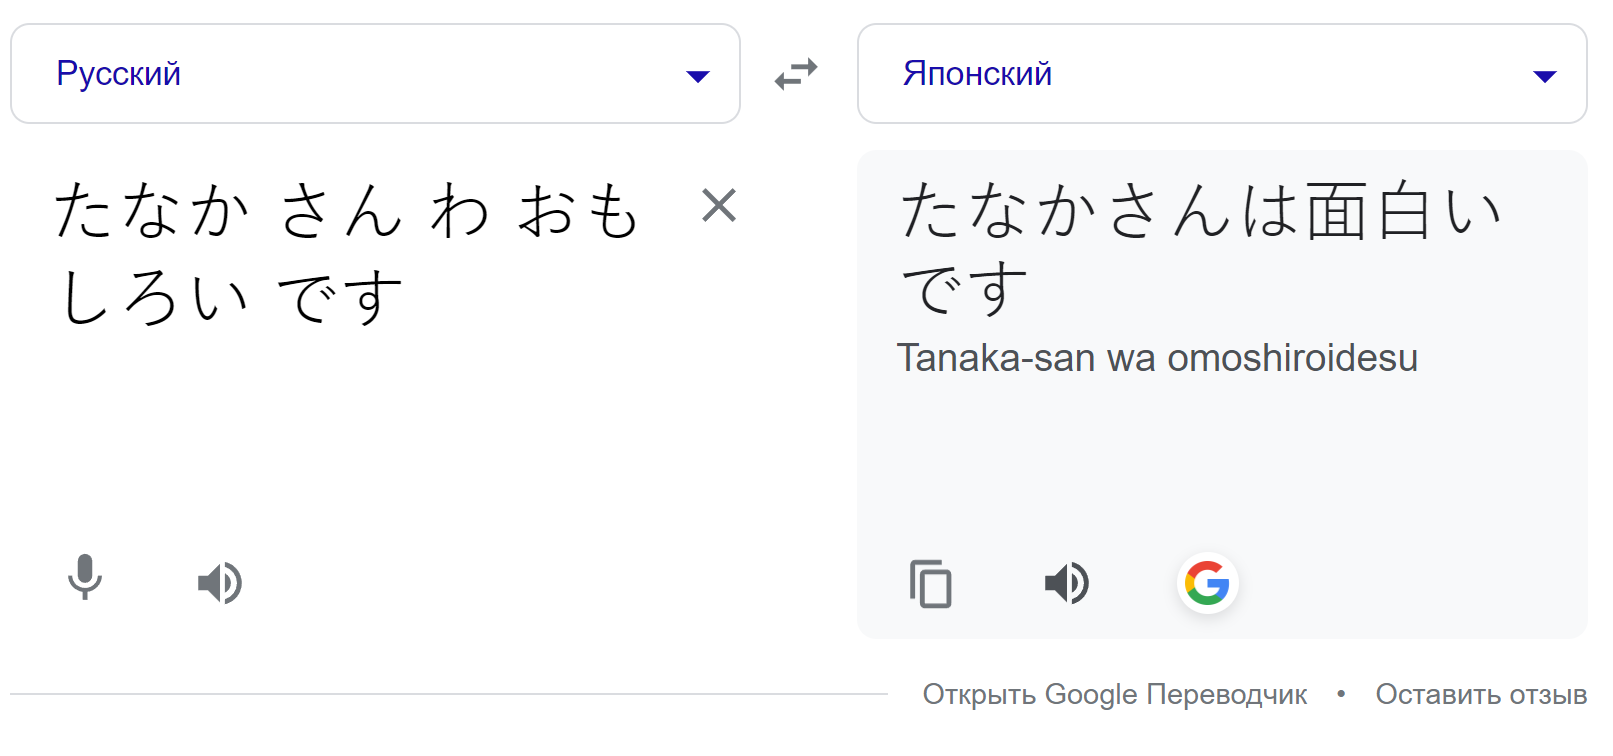

**Протестируем наш автомат на реальной фразе:**

たなか さん わ おもしろい です

Выводом будет:

*танака сан уа омощирои дэс*

Здесь видна нормальная работа программы и правило редукции У на конце предложения

**Протестируем удлиннение:**

Удлиннение согласной:
しっぺろ
*щиппэро*

Удлиннение N, удлиннение гласной с помощью такой же гласной:
しっんろお
*щиннроо*

Удлиннение N с последующей заменой обоих звуков на М, удлиннение гласной с помощью другой гласной
しっんぽう
*щиммпоо*

**Протестируем образование новых слогов с помощью малых символов**

С большим символом: そにや *сонийа*

С малым символом: そにゃ *соня*

Таким образом различаются, например, японские слова *десять* и *свобода*

**Протестируем редукцию/выпадение У и И**

И между глухими: ほちき хочики -> *хочьки*

У между глухими: さすけ сасуке -> *сасъкэ*

У в конце предложения в суффиксе СУ: ほす です
*хосу дэс*

Теперь приведем некоторые **ошибочные** последовательности:

っぺろ начинается с малого っ

そすゃ содержит малый символ не после слога формата согл+И

しっんぽhお содержит не японский символ

Я не включила эти последовательности в файл, так как одна такая последовательность делает всю строку невалидной

### Запуск программы

In [53]:
with open('input_file.txt', encoding='utf-8') as file:
    input_str = file.readline().strip()  # japanese word
pos_in_input_str = 0
output_str = ''  # russian
error_occurred = False  # check if input is invalid
need_clarifying_stack = deque()
# symbols that are interpreted depending on those in front of them

begin_word()

print()
print('_______________________________________________')
print()
if error_occurred:
    print(f'{input_str} is not a valid hiragana line')
    print(f'here is what i managed to transliterate: {output_str.strip()}')
else:
    print(input_str)
    print(output_str.strip())

im in begin_word, here is the stack: [ ]
im in cons_from_cons_plus_vow_syll, here is the stack: [ ]
im in vow_from_cons_plus_vow_syll, here is the stack: [ ]
im in cons_from_cons_plus_vow_syll, here is the stack: [ ]
im in vow_from_cons_plus_vow_syll, here is the stack: [ ]
im in cons_from_cons_plus_vow_syll, here is the stack: [ ]
im in vow_from_cons_plus_vow_syll, here is the stack: [ ]
im in begin_word, here is the stack: [ ]
im in cons_from_cons_plus_vow_syll, here is the stack: [ ]
im in vow_from_cons_plus_vow_syll, here is the stack: [ ]
im in n_syll, here is the stack: [ ]
im in begin_word, here is the stack: [ ]
im in cons_from_cons_plus_vow_syll, here is the stack: [ ]
im in vow_from_cons_plus_vow_syll, here is the stack: [ ]
im in begin_word, here is the stack: [ ]
im in vow_syll, here is the stack: [ ]
im in new_syll, here is the stack: [ ]
im in cons_from_cons_plus_vow_syll, here is the stack: [ ]
im in vow_from_cons_plus_vow_syll, here is the stack: [ ]
im in cons_from_con